In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

#import shap

import sys
sys.path.append('/home/user/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import myfilter, num_transient, sliding_sum_window, select_index, add_padding
from PreProcessingFunctions import WS
from PreProcessingFunctions import rename_and_convert_to_txt

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory
from XAI_FCN import plot_grad_cam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:    
    for gpu in gpus:
        tensorflow.config.set_logical_device_configuration(
            gpu,
            [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.metrics    import AUC, Precision, Recall
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

data_folder = '/home/user/thesis_ws/src/ML_Levers_Knobs/DATA/1D_KNOB_Tx+Tz_ScalNorm/'

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data

# Load the data
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

WS_B = 2000
N_CLASS = 6
DISP_LABELS = ["0", "1", "2", "3", "4", "5"]

2024-06-04 00:52:01.688138: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 00:52:02.539837: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-04 00:52:03.086970: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 00:52:03.120095: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

X_data shape: (629, 2000, 2)
y_data shape: (629,)
X_data.[0] shape:  (2000, 2)
TOTAL DATA: 629  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (377, 2000, 2)    ||  Dimensions of y_train: (377,)
Dimensions of X_test:  (126, 2000, 2)    ||  Dimensions of y_test:  (126,)
Dimensions of X_val:   (126, 2000, 2)    ||  Dimensions of y_val:   (126,)


# 1 CONVs

2024-06-04 00:52:03.391844: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 00:52:03.392233: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 00:52:03.392554: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 197, 64)   │      2,624 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 197, 64)   │      2,624 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 98, 64)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 98, 64)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 6272)      │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 6272)      │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12544)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    802,880 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 6)         │        390 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 808,518 (3.08 MB)

 Trainable params: 808,518 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32


I0000 00:00:1717455124.631001   37463 service.cc:145] XLA service 0x7ed998004090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717455124.631026   37463 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-06-04 00:52:04.662342: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-04 00:52:04.798819: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 1/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.2188 - loss: 1.7541

I0000 00:00:1717455126.983067   37463 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 0.3398 - loss: 1.6497 - val_accuracy: 0.3968 - val_loss: 1.4041
Epoch 2/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5412 - loss: 1.0862 - val_accuracy: 0.5079 - val_loss: 1.0861
Epoch 3/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6782 - loss: 0.8449 - val_accuracy: 0.6429 - val_loss: 0.8831
Epoch 4/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7309 - loss: 0.7140 - val_accuracy: 0.6508 - val_loss: 0.9820
Epoch 5/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7304 - loss: 0.7245 - val_accuracy: 0.6984 - val_loss: 0.9037
Epoch 6/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7676 - loss: 0.6050 - val_accuracy: 0.6984 - val_loss: 0.8051
Epoch 7/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8384 - loss: 0.4644 - val_accuracy: 0.7381 - val_loss: 0.8055
Epoch 8/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8126 - loss: 0.4905 - val_accuracy: 0.7540 - val_loss: 0.7882
E

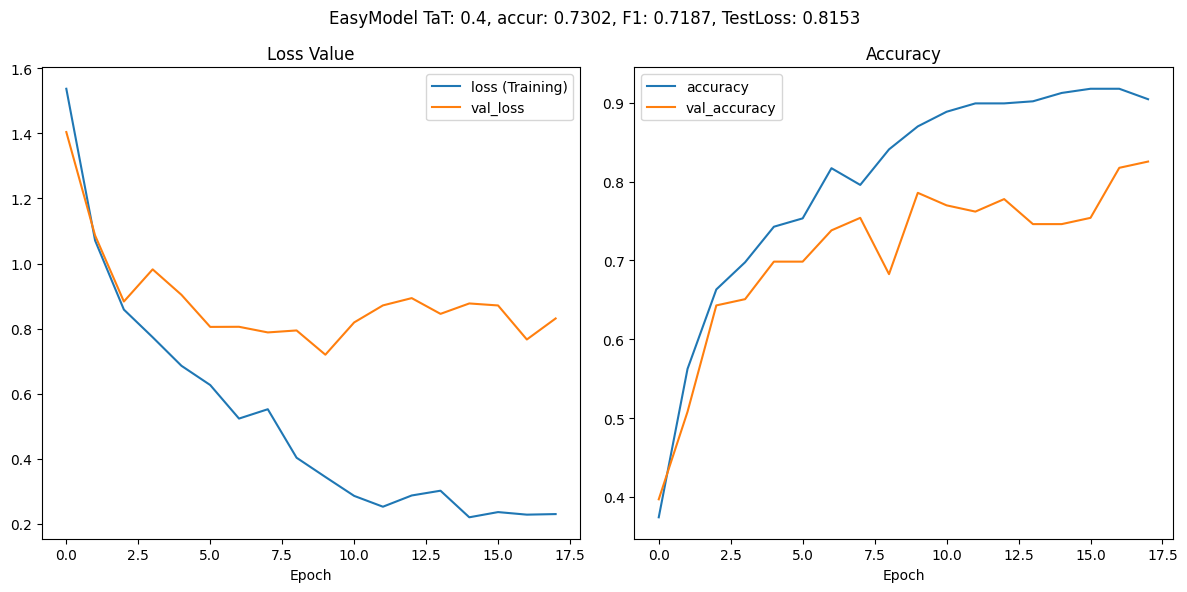

Train loss: 0.22977514564990997
Test val_loss: 0.8310748338699341
Train accuracy: 0.9045093059539795
Accuracy Score: 0.7301587301587301
F1 Score: 0.7186781248421615
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.86      0.86        29
         1.0       0.68      0.63      0.66        30
         2.0       0.70      0.72      0.71        29
         3.0       1.00      0.93      0.96        14
         4.0       0.56      1.00      0.72         9
         5.0       0.50      0.33      0.40        15

    accuracy                           0.73       126
   macro avg       0.72      0.75      0.72       126
weighted avg       0.73      0.73      0.72       126



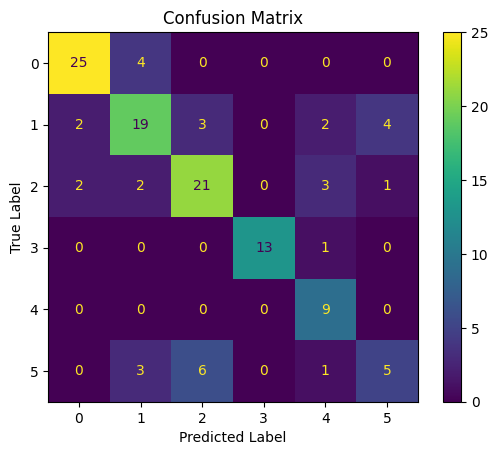

In [2]:
def build_easyModel():
    input_layer = Input(shape=(WS_B, 1))
    x = Conv1D(64, kernel_size=40, strides=10, activation='relu')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)

    z = Conv1D(64, kernel_size=40, strides=10, activation='relu')(input_layer)
    z = MaxPooling1D(pool_size=2)(z)
    z = Flatten()(z)

    merged = concatenate([x, z])
    common_layer = Dense(64, activation='relu')(merged)
    output_layer = Dense(N_CLASS, activation='softmax')(common_layer)
    model = Model(inputs=[input_layer, input_layer], outputs=output_layer)
    return model

model_name = "1D_easy1Conv"
model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# SPLITTING DATASET x+z
X_x_data = X_data[:, :, 0]
X_z_data  = X_data[:, :, 1]

X_train_x,  X_temp_x = train_test_split(X_x_data, test_size=TEST_SIZE, random_state=42)
X_val_x,    X_test_x = train_test_split(X_temp_x , test_size=0.5, random_state=42)

X_train_z,   X_temp_z  = train_test_split(X_z_data, test_size=TEST_SIZE, random_state=42)
X_val_z,     X_test_z  = train_test_split(X_temp_z , test_size=0.5, random_state=42)

y_train, y_temp = train_test_split(y_data, test_size=TEST_SIZE, random_state=42)
y_val  , y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit([X_train_x, X_train_z], y_train, epochs=32, batch_size=32, 
                    validation_data=([X_val_x, X_val_z], y_val), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test_x, X_test_z], y_test)

# Predict labels for test data
y_pred = model.predict([X_test_x, X_test_z])
y_pred_labels = np.argmax(y_pred, axis=1)

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 2 CONVs 

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 498, 128)  │      1,408 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 498, 128)  │      1,408 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 249, 128)  │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 249, 128)  │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 246, 64)   │     32,832 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 246, 64)   │     32,832 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 123, 64)   │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 123, 64)   │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 7872)      │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 7872)      │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 15744)     │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 15744)     │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │  1,007,680 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 6)         │        390 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,076,550 (4.11 MB)

 Trainable params: 1,076,550 (4.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32


2024-06-04 00:52:16.075170: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3322 - loss: 1.7803

2024-06-04 00:52:18.300982: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 315ms/step - accuracy: 0.3265 - loss: 1.7566 - val_accuracy: 0.3492 - val_loss: 1.4536
Epoch 2/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4603 - loss: 1.3051 - val_accuracy: 0.4603 - val_loss: 1.2234
Epoch 3/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5556 - loss: 1.0540 - val_accuracy: 0.5397 - val_loss: 1.1128
Epoch 4/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6901 - loss: 0.8465 - val_accuracy: 0.6746 - val_loss: 0.9317
Epoch 5/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6727 - loss: 0.8177 - val_accuracy: 0.6270 - val_loss: 1.0555
Epoch 6/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7511 - loss: 0.6590 - val_accuracy: 0.6032 - val_loss: 1.1718
Epoch 7/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7706 - loss: 0.5937 - val_accuracy: 0.6984 - val_loss: 0.9004
Epoch 8/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8092 - loss: 0.5009 - val_accuracy: 0.6746 - val_loss: 0

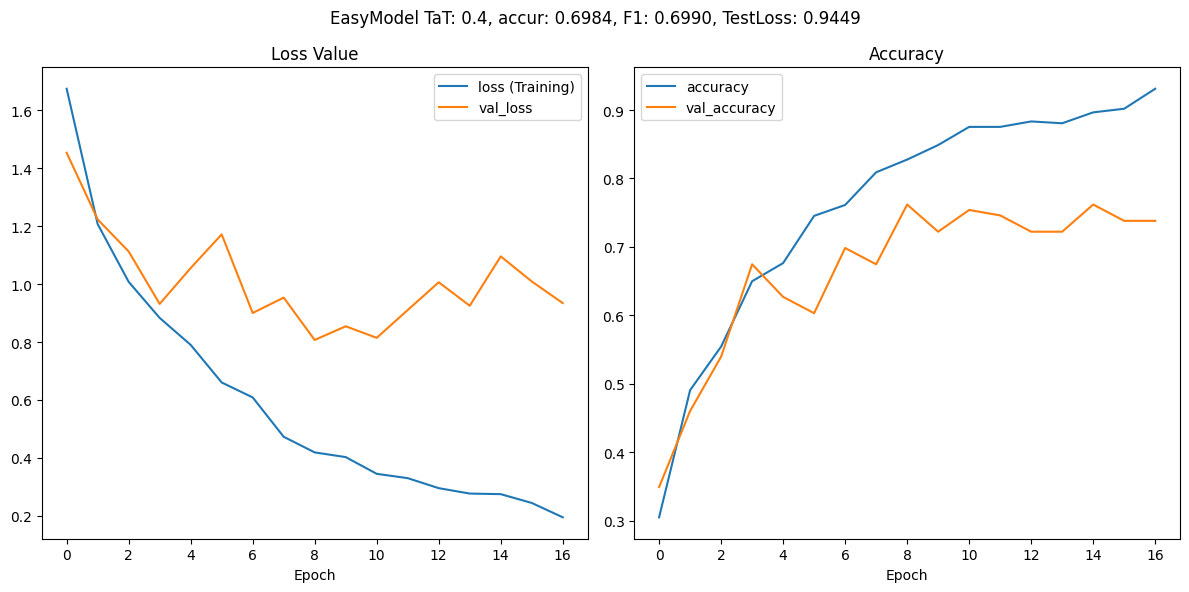

Train loss: 0.1948300004005432
Test val_loss: 0.934524655342102
Train accuracy: 0.931034505367279
Accuracy Score: 0.6984126984126984
F1 Score: 0.698961922483333
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.83      0.79        29
         1.0       0.56      0.63      0.59        30
         2.0       0.68      0.66      0.67        29
         3.0       0.93      1.00      0.97        14
         4.0       0.73      0.89      0.80         9
         5.0       0.67      0.27      0.38        15

    accuracy                           0.70       126
   macro avg       0.72      0.71      0.70       126
weighted avg       0.70      0.70      0.69       126



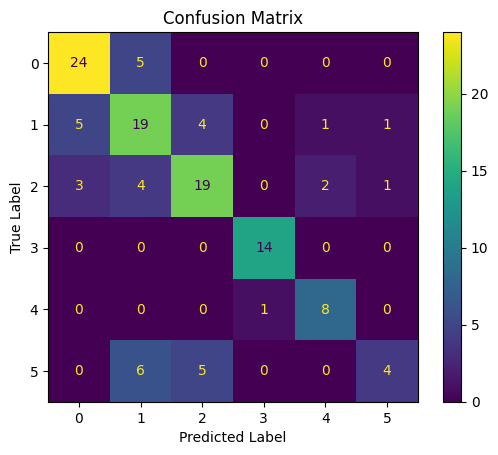

In [3]:
def build_easyModel():
    input = Input(shape=(WS_B, 1))

    x = Conv1D(128, kernel_size=10, strides=4, activation='relu')(input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(64, kernel_size=4, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)

    z = Conv1D(128, kernel_size=10, strides=4, activation='relu')(input)
    z = MaxPooling1D(pool_size=2)(z)
    z = Conv1D(64, kernel_size=4, activation='relu')(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Flatten()(z)

    merged = concatenate([x, z])
    merged = Dropout(0.2)(merged)
    common_layer = Dense(64, activation='relu')(merged)
    output_layer = Dense(N_CLASS, activation='softmax')(common_layer)

    model = Model(inputs=[input, input], outputs=output_layer)
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=AdamW(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# SPLITTING DATASET x+z
X_x_data = X_data[:, :, 0]
X_z_data  = X_data[:, :, 1]

X_train_x,  X_temp_x = train_test_split(X_x_data, test_size=TEST_SIZE, random_state=42)
X_val_x,    X_test_x = train_test_split(X_temp_x , test_size=0.5, random_state=42)

X_train_z,   X_temp_z  = train_test_split(X_z_data, test_size=TEST_SIZE, random_state=42)
X_val_z,     X_test_z  = train_test_split(X_temp_z , test_size=0.5, random_state=42)

y_train, y_temp = train_test_split(y_data, test_size=TEST_SIZE, random_state=42)
y_val  , y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit([X_train_x, X_train_z], y_train, epochs=32, batch_size=32, 
                    validation_data=([X_val_x, X_val_z], y_val), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test_x, X_test_z], y_test)

# Predict labels for test data
y_pred = model.predict([X_test_x, X_test_z])
y_pred_labels = np.argmax(y_pred, axis=1)

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [4]:
# model_name = "1D_LDG_F+F_2Cnv_94"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_easyModel)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# 3 CONVs

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 197, 256)  │     10,496 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 197, 256)  │     10,496 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 98, 256)   │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 98, 256)   │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 23, 128)   │    262,272 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 23, 128)   │    262,272 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 11, 128)   │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 11, 128)   │          0 │ conv1d_10[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 10, 128)   │     32,896 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 10, 128)   │     32,896 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 5, 128)    │          0 │ conv1d_8[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 5, 128)    │          0 │ conv1d_11[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 640)       │          0 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 640)       │          0 │ max_pooling1d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 1280)      │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │    163,968 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 6)         │        774 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 776,070 (2.96 MB)

 Trainable params: 776,070 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2478 - loss: 1.7152 

2024-06-04 00:52:35.021614: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 508ms/step - accuracy: 0.2734 - loss: 1.6859 - val_accuracy: 0.4206 - val_loss: 1.4341
Epoch 2/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5164 - loss: 1.2259 - val_accuracy: 0.5000 - val_loss: 1.2209
Epoch 3/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5644 - loss: 1.0624 - val_accuracy: 0.5952 - val_loss: 1.0062
Epoch 4/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6413 - loss: 0.9177 - val_accuracy: 0.6190 - val_loss: 0.9210
Epoch 5/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6884 - loss: 0.7491 - val_accuracy: 0.6667 - val_loss: 0.8048
Epoch 6/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7105 - loss: 0.7212 - val_accuracy: 0.6190 - val_loss: 0.8569
Epoch 7/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7312 - loss: 0.6772 - val_accuracy: 0.6508 - val_loss: 0.8068
Epoch 8/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7469 - loss: 0.6363 - val_accuracy: 0.7143 - val_loss: 0.6

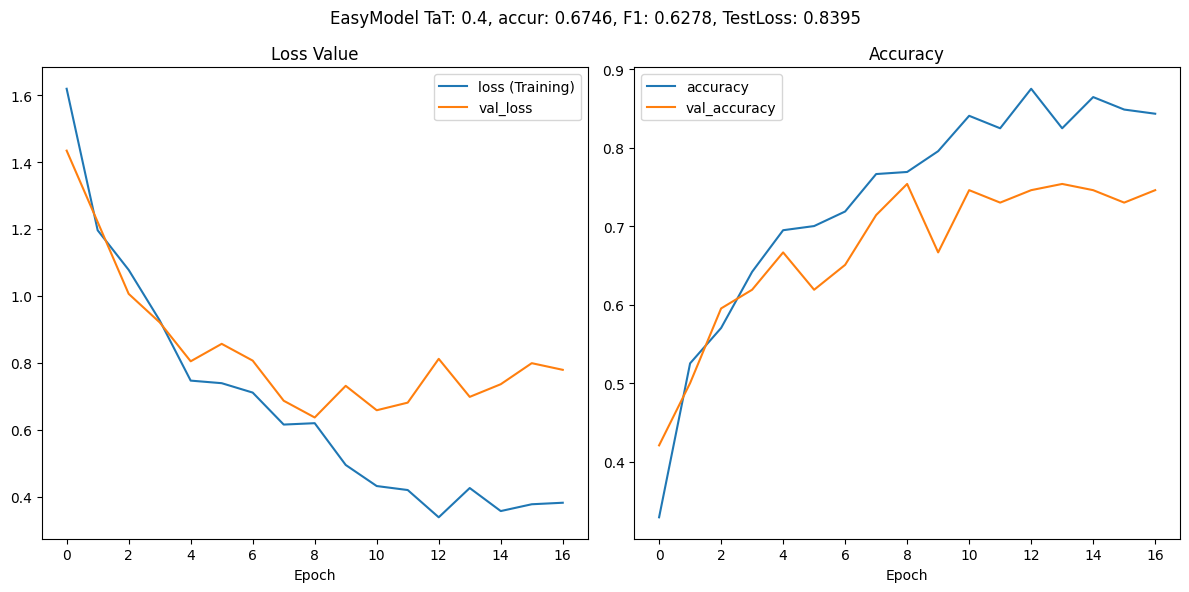

Train loss: 0.38217663764953613
Test val_loss: 0.7792477607727051
Train accuracy: 0.8435013294219971
Accuracy Score: 0.6746031746031746
F1 Score: 0.6278292877186952
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.83      0.86        29
         1.0       0.67      0.60      0.63        30
         2.0       0.58      0.76      0.66        29
         3.0       0.85      0.79      0.81        14
         4.0       0.42      0.89      0.57         9
         5.0       1.00      0.13      0.24        15

    accuracy                           0.67       126
   macro avg       0.73      0.67      0.63       126
weighted avg       0.74      0.67      0.66       126



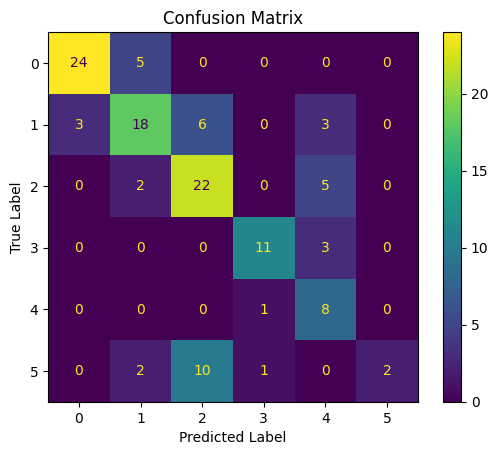

In [5]:
def build_easyModel():
    input_x = Input(shape=(WS_B, 1))
    input_z = Input(shape=(WS_B, 1))

    x = Conv1D(256, kernel_size=40, strides=10, activation='relu')(input_x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=8, strides=4, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=2, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)

    z = Conv1D(256, kernel_size=40, strides=10, activation='relu')(input_z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Conv1D(128, kernel_size=8, strides=4, activation='relu')(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Conv1D(128, kernel_size=2, activation='relu')(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Flatten()(z)

    merged = concatenate([x, z])
    common_layer = Dense(128, activation='relu')(merged)
    common_layer = Dropout(0.2)(common_layer)
    output_layer = Dense(N_CLASS, activation='softmax')(common_layer)

    model = Model(inputs=[input_x, input_z], outputs=output_layer)
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=AdamW(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# SPLITTING DATASET x+z
X_x_data = X_data[:, :, 0]
X_z_data  = X_data[:, :, 1]

X_train_x,  X_temp_x = train_test_split(X_x_data, test_size=TEST_SIZE, random_state=42)
X_val_x,    X_test_x = train_test_split(X_temp_x , test_size=0.5, random_state=42)

X_train_z,   X_temp_z  = train_test_split(X_z_data, test_size=TEST_SIZE, random_state=42)
X_val_z,     X_test_z  = train_test_split(X_temp_z , test_size=0.5, random_state=42)

y_train, y_temp = train_test_split(y_data, test_size=TEST_SIZE, random_state=42)
y_val  , y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit([X_train_x, X_train_z], y_train, epochs=32, batch_size=32, 
                    validation_data=([X_val_x, X_val_z], y_val), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test_x, X_test_z], y_test)

# Predict labels for test data
y_pred = model.predict([X_test_x, X_test_z])
y_pred_labels = np.argmax(y_pred, axis=1)

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [6]:
# model_name = "1D_FLAP_F+F_4Cnv_98"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_easyModel)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# 4 CONVs or Still "COMPLEX"

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 496, 256)  │      5,376 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 496, 256)  │      5,376 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 248, 256)  │          0 │ conv1d_12[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 248, 256)  │          0 │ conv1d_16[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 59, 256)   │  1,048,832 │ max_pooling1d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 59, 256)   │  1,048,832 │ max_pooling1d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 59, 256)   │          0 │ conv1d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 59, 256)   │          0 │ conv1d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 52, 128)   │    262,272 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 52, 128)   │    262,272 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 26, 128)   │          0 │ conv1d_14[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 26, 128)   │          0 │ conv1d_18[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 23, 64)    │     32,832 │ max_pooling1d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 23, 64)    │     32,832 │ max_pooling1d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 11, 64)    │          0 │ conv1d_15[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 11, 64)    │          0 │ conv1d_19[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 704)       │          0 │ max_pooling1d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 704)       │          0 │ max_pooling1d_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 1408)      │          0 │ flatten_6[0][0],

 Total params: 2,789,190 (10.64 MB)

 Trainable params: 2,789,190 (10.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32


2024-06-04 00:52:46.872766: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2727 - loss: 1.7533

2024-06-04 00:52:52.796814: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 647ms/step - accuracy: 0.2842 - loss: 1.7320 - val_accuracy: 0.3651 - val_loss: 1.5358
Epoch 2/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4972 - loss: 1.2432 - val_accuracy: 0.5079 - val_loss: 1.2964
Epoch 3/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5522 - loss: 1.1429 - val_accuracy: 0.5714 - val_loss: 1.0995
Epoch 4/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6507 - loss: 0.8938 - val_accuracy: 0.5238 - val_loss: 1.2136
Epoch 5/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6897 - loss: 0.8670 - val_accuracy: 0.6111 - val_loss: 0.8765
Epoch 6/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7209 - loss: 0.6682 - val_accuracy: 0.5873 - val_loss: 0.9869
Epoch 7/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7984 - loss: 0.5253 - val_accuracy: 0.5873 - val_loss: 1.0983
Epoch 8/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8054 - loss: 0.5459 - val_accuracy: 0.6667 - val_loss: 

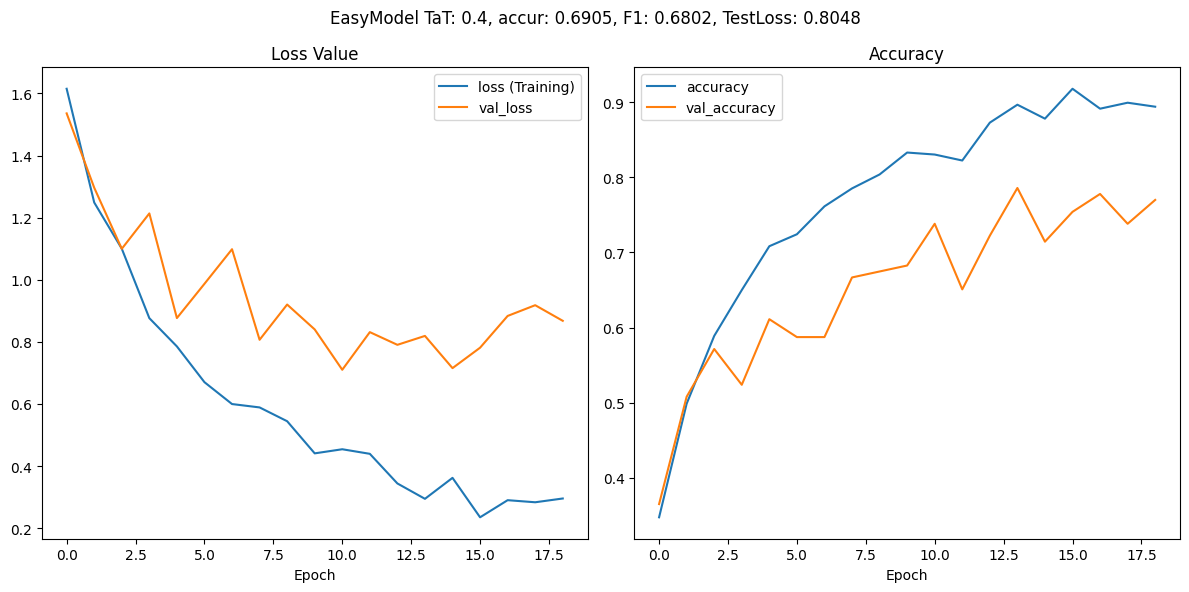

Train loss: 0.2953544557094574
Test val_loss: 0.8676573038101196
Train accuracy: 0.8938992023468018
Accuracy Score: 0.6904761904761905
F1 Score: 0.6801851851851851
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.83      0.86        29
         1.0       0.73      0.63      0.68        30
         2.0       0.59      0.69      0.63        29
         3.0       1.00      0.71      0.83        14
         4.0       0.56      1.00      0.72         9
         5.0       0.38      0.33      0.36        15

    accuracy                           0.69       126
   macro avg       0.69      0.70      0.68       126
weighted avg       0.71      0.69      0.69       126



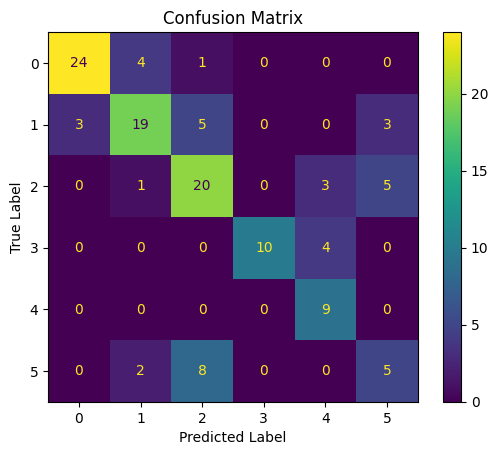

In [7]:
def build_easyModel():
    input_x = Input(shape=(WS_B, 1))
    input_z = Input(shape=(WS_B, 1))

    # Branch for Force_X
    x = Conv1D(filters=256, kernel_size=20, strides=4, activation='relu')(input_x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=256, kernel_size=16, strides=4, activation='relu')(x)
    x = Dropout(rate=0.1)(x)
    x = Conv1D(filters=128, kernel_size=8, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=64, kernel_size=4, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)

    # Branch for Force_Z
    z = Conv1D(filters=256, kernel_size=20, strides=4, activation='relu')(input_z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Conv1D(filters=256, kernel_size=16, strides=4, activation='relu')(z)
    z = Dropout(rate=0.1)(z)
    z = Conv1D(filters=128, kernel_size=8, activation='relu')(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Conv1D(filters=64, kernel_size=4, activation='relu')(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Flatten()(z)

    # Merging branches
    merged = concatenate([x, z])
    common_layer = Dense(64, activation='relu')(merged)
    output_layer = Dense(N_CLASS, activation='softmax')(common_layer)

    model = Model(inputs=[input_x, input_z], outputs=output_layer)
    return model


model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# SPLITTING DATASET x+z
X_x_data = X_data[:, :, 0]
X_z_data  = X_data[:, :, 1]

X_train_x,  X_temp_x = train_test_split(X_x_data, test_size=TEST_SIZE, random_state=42)
X_val_x,    X_test_x = train_test_split(X_temp_x , test_size=0.5, random_state=42)

X_train_z,   X_temp_z  = train_test_split(X_z_data, test_size=TEST_SIZE, random_state=42)
X_val_z,     X_test_z  = train_test_split(X_temp_z , test_size=0.5, random_state=42)

y_train, y_temp = train_test_split(y_data, test_size=TEST_SIZE, random_state=42)
y_val  , y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit([X_train_x, X_train_z], y_train, epochs=32, batch_size=32, 
                    validation_data=([X_val_x, X_val_z], y_val), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test_x, X_test_z], y_test)

# Predict labels for test data
y_pred = model.predict([X_test_x, X_test_z])
y_pred_labels = np.argmax(y_pred, axis=1)

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [8]:
# model_name = "1D_FLAP_F+F_4Cnv_98"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_easyModel)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# 5 CONVS